# pip & import

In [1]:
!pip install catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 9.1 MB/s eta 0:00:00


In [2]:
!pip install micropip

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 1.1 MB/s eta 0:00:00


In [3]:
!pip install matplotlib-venn

In [4]:
#hiddencell
import micropip
await micropip.install("seaborn")

import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

fe = fm.FontEntry(fname = 'MaruBuri-Regular.otf', name = 'MaruBuri')
fm.fontManager.ttflist.insert(0, fe)
plt.rc('font', family='MaruBuri')

In [5]:
import os
import random
import numpy as np
import pandas as pd

In [6]:
!rm -rf ~/.cache/matplotlib
!sudo apt-get install fonts-nanum
!sudo fc-cache -fv

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 15 not upgraded.
Need to get 10.3 MB of archives.
After this operation, 34.1 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 fonts-nanum all 20200506-1 [10.3 MB]
Fetched 10.3 MB in 0s (35.8 MB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 78, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package fonts-nanum.
(Reading database ... 120882 files and direc

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import font_manager as fm
plt.rc('font', family='NanumBarunGothic')
sns.set(font="NanumBarunGothic",
        rc={"axes.unicode_minus":False},
        style='darkgrid')
plt.rcParams['font.family'] = 'NanumBarunGothic'

In [8]:
plt.rc('font', family='NanumBarunGothic')
# 한글 폰트 사용 시 마이너스 폰트 깨짐 방지
plt.rc('axes', unicode_minus=False)

# **대구 교통 사고 피해 예측 AI 경진대회**

## seed 고정 & 함수 정의


In [9]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

seed_everything(42)

## **데이터 불러오기 및 상위행 확인**  

train.csv, test.csv 파일을 로드하여 상위행을 출력해 봅시다

In [10]:
train_org = pd.read_csv('train.csv')
test_org = pd.read_csv('test.csv')

In [11]:
train_df = train_org.copy()
test_df = test_org.copy()

In [12]:
train_df['시'] = train_df['시군구'].apply(lambda x: x.split()[0] if len(x.split()) > 0 else '')
train_df['군'] = train_df['시군구'].apply(lambda x: x.split()[1] if len(x.split()) > 1 else '')
train_df['구'] = train_df['시군구'].apply(lambda x: x.split()[2] if len(x.split()) > 2 else '')

## **train, test 데이터 기간 확인하기**  

학습(train) 데이터의 기간과 예측 대상이 되는 test 데이터의 기간을 살펴 봅니다

In [13]:
display(f"train : {train_org.iloc[0]['사고일시']} ~ {train_org.iloc[-1]['사고일시']}")
display(f"test : {test_org.iloc[0]['사고일시']} ~ {test_org.iloc[-1]['사고일시']}")

'train : 2019-01-01 00 ~ 2021-12-31 23'

'test : 2022-01-01 01 ~ 2022-12-31 21'

## **예측 대상 확인하기**

sample_submission.csv를 로드하여 출력 형식을 확인해 봄으로서,
대회 페이지 규칙에 기술되어 있는, 예측 대상이 무엇인지 확인해 봅시다.

최종적으로 예측해야 하는 값은 'ECLO'(인명피해 심각도) 값입니다.

그러나, train데이터 컬럼에 있는 '사망자수', '중상자수', '경상자수', '부상자수'를 각각 예측하여 ECLO 예측값을 구할 수도 있습니다. 즉, ECLO 값을 예측하는 단일 모델로 접근할 수도,  각각을 별도로 예측하는 모델로 접근할 수도 있습니다.

In [14]:
sample_submission = pd.read_csv("sample_submission.csv")
sample_submission.head()

,ID,ECLO
0,ACCIDENT_39609,0
1,ACCIDENT_39610,0
2,ACCIDENT_39611,0
3,ACCIDENT_39612,0
4,ACCIDENT_39613,0


## **데이터 전처리**  

현재 '사고일시', '시군구', '도로형태' 컬럼은 반복되는 패턴으로 여러 정보를 포함하고 있습니다
이런 반복되는 패턴을 일반화하면 pandas에서 제공하는 str.extract를 통해 한 번에 추출 가능합니다  

## **파생 변수 생성 1 : 날짜, 시간정보 생성**

'사고일시' 컬럼으로 부터 연도, 월, 일, 시간 정보 추출 및 변환 합니다

In [15]:
time_pattern = r'(\d{4})-(\d{1,2})-(\d{1,2}) (\d{1,2})'

train_df[['연', '월', '일', '시간']] = train_org['사고일시'].str.extract(time_pattern)
train_df[['연', '월', '일', '시간']] = train_df[['연', '월', '일', '시간']].apply(pd.to_numeric) # 추출된 문자열을 수치화해줍니다
train_df = train_df.drop(columns=['사고일시']) # 정보 추출이 완료된 '사고일시' 컬럼은 제거합니다

# 해당 과정을 test_x에 대해서도 반복해줍니다
test_df[['연', '월', '일', '시간']] = test_org['사고일시'].str.extract(time_pattern)
test_df[['연', '월', '일', '시간']] = test_df[['연', '월', '일', '시간']].apply(pd.to_numeric)
test_df = test_df.drop(columns=['사고일시'])

display(f"columns of train_df : {train_df.columns}")
display(f"columns of test_df : {test_df.columns}")

"columns of train_df : Index(['ID', '요일', '기상상태', '시군구', '도로형태', '노면상태', '사고유형', '사고유형 - 세부분류',\n       '법규위반', '가해운전자 차종', '가해운전자 성별', '가해운전자 연령', '가해운전자 상해정도', '피해운전자 차종',\n       '피해운전자 성별', '피해운전자 연령', '피해운전자 상해정도', '사망자수', '중상자수', '경상자수', '부상자수',\n       'ECLO', '시', '군', '구', '연', '월', '일', '시간'],\n      dtype='object')"

"columns of test_df : Index(['ID', '요일', '기상상태', '시군구', '도로형태', '노면상태', '사고유형', '연', '월', '일', '시간'], dtype='object')"

## **파생 변수 생성 2 : 공간(위치) 정보 생성**

'시군구' 컬럼으로부터 의미 있는 공산 정보를 추출 및 변환 합니다

In [16]:
location_pattern = r'(\S+) (\S+) (\S+)'

train_df[['도시', '구', '동']] = train_org['시군구'].str.extract(location_pattern)
train_df = train_df.drop(columns=['시군구'])

test_df[['도시', '구', '동']] = test_org['시군구'].str.extract(location_pattern)
test_df = test_df.drop(columns=['시군구'])

display(f"columns of train_df : {train_df.columns}")
display(f"columns of test_df : {test_df.columns}")

"columns of train_df : Index(['ID', '요일', '기상상태', '도로형태', '노면상태', '사고유형', '사고유형 - 세부분류', '법규위반',\n       '가해운전자 차종', '가해운전자 성별', '가해운전자 연령', '가해운전자 상해정도', '피해운전자 차종',\n       '피해운전자 성별', '피해운전자 연령', '피해운전자 상해정도', '사망자수', '중상자수', '경상자수', '부상자수',\n       'ECLO', '시', '군', '구', '연', '월', '일', '시간', '도시', '동'],\n      dtype='object')"

"columns of test_df : Index(['ID', '요일', '기상상태', '도로형태', '노면상태', '사고유형', '연', '월', '일', '시간', '도시',\n       '구', '동'],\n      dtype='object')"

## **파생 변수 추출 3 : 도로 형태 정보 추출**  

'도로형태' 컬럼은 '단일로 - 기타'와 같은 패턴으로 구성되어 있습니다. 이를 두종류의 독립된 정보로 보고 두개의 컬럼으로 분리하여 생성합니다.

In [17]:
road_pattern = r'(.+) - (.+)'

train_df[['도로형태1', '도로형태2']] = train_org['도로형태'].str.extract(road_pattern)
train_df = train_df.drop(columns=['도로형태'])

test_df[['도로형태1', '도로형태2']] = test_org['도로형태'].str.extract(road_pattern)
test_df = test_df.drop(columns=['도로형태'])

display(f"columns of train_df : {train_df.columns}")
display(f"columns of test_df : {test_df.columns}")

"columns of train_df : Index(['ID', '요일', '기상상태', '노면상태', '사고유형', '사고유형 - 세부분류', '법규위반', '가해운전자 차종',\n       '가해운전자 성별', '가해운전자 연령', '가해운전자 상해정도', '피해운전자 차종', '피해운전자 성별',\n       '피해운전자 연령', '피해운전자 상해정도', '사망자수', '중상자수', '경상자수', '부상자수', 'ECLO', '시',\n       '군', '구', '연', '월', '일', '시간', '도시', '동', '도로형태1', '도로형태2'],\n      dtype='object')"

"columns of test_df : Index(['ID', '요일', '기상상태', '노면상태', '사고유형', '연', '월', '일', '시간', '도시', '구', '동',\n       '도로형태1', '도로형태2'],\n      dtype='object')"

## **전처리 결과 확인**

지금까지 전처리한 결과를 확인해 봅시다

In [18]:
train_df.columns

Index(['ID', '요일', '기상상태', '노면상태', '사고유형', '사고유형 - 세부분류', '법규위반', '가해운전자 차종',
       '가해운전자 성별', '가해운전자 연령', '가해운전자 상해정도', '피해운전자 차종', '피해운전자 성별',
       '피해운전자 연령', '피해운전자 상해정도', '사망자수', '중상자수', '경상자수', '부상자수', 'ECLO', '시',
       '군', '구', '연', '월', '일', '시간', '도시', '동', '도로형태1', '도로형태2'],
      dtype='object')

In [19]:
test_df.columns

Index(['ID', '요일', '기상상태', '노면상태', '사고유형', '연', '월', '일', '시간', '도시', '구', '동',
       '도로형태1', '도로형태2'],
      dtype='object')

## **train, test 데이터의 독립변수, 종속 변수 분리**

모델 추론 시점에서 획득할 수 있는 데이터는 학습 시점에서 활용할 수 있는 데이터와 다를 수 있습니다  
그렇기에 본 baseline에서는 test 시점에서만 활용할 수 있는 데이터들(test의 column들)만 사용하여 train 데이터를 구성했습니다

train_df 중에서 test_x가 가진 column들만 추출하여 train_x(독립변수)를 구성하고, train_df 중에서 예측 목표인 EPDO를 추출하여 train_y(종속변수)를 구성합니다

In [20]:
test_features = test_df.drop(columns=['ID']).copy()
train_features = train_df[test_features.columns].copy()
train_target = train_df['ECLO'].copy()

## **범주형(Categorical) 변수, 수치형 변수로 변환하기**

모델 학습을 위해 train_x의 문자열 타입의 컬럼들을 추출하고, LabelEncoder를 활용하여 이 컬럼들을 모두 수치형 변수로 변환해 보겠습니다

In [21]:
from sklearn.preprocessing import LabelEncoder

categorical_features = list(train_features.dtypes[train_features.dtypes == "object"].index)
# 추출된 문자열 변수 확인
display(categorical_features)

for i in categorical_features:
    le = LabelEncoder()
    le=le.fit(train_features[i])
    train_features[i]=le.transform(train_features[i])

    for case in np.unique(test_features[i]):
        if case not in le.classes_:
            le.classes_ = np.append(le.classes_, case)
    test_features[i]=le.transform(test_features[i])

display(train_features.head())
display(test_features.head())

['요일', '기상상태', '노면상태', '사고유형', '도시', '구', '동', '도로형태1', '도로형태2']

,요일,기상상태,노면상태,사고유형,연,월,일,시간,도시,구,동,도로형태1,도로형태2
0,6,2,0,0,2019,1,1,0,0,7,40,2,5
1,6,5,0,0,2019,1,1,0,0,1,4,2,5
2,6,2,0,0,2019,1,1,1,0,6,66,2,5
3,6,2,0,1,2019,1,1,2,0,4,79,2,5
4,6,2,0,1,2019,1,1,4,0,3,129,2,5


,요일,기상상태,노면상태,사고유형,연,월,일,시간,도시,구,동,도로형태1,도로형태2
0,5,2,0,0,2022,1,1,1,0,6,99,0,3
1,5,2,0,0,2022,1,1,1,0,6,168,2,5
2,5,2,0,1,2022,1,1,4,0,6,117,0,3
3,5,2,0,1,2022,1,1,4,0,6,126,2,5
4,5,2,0,1,2022,1,1,6,0,1,4,0,3


## **Model Train & Prediction**

전체 학습 데이터에 대하여 학습후 최종 예측을 합니다. 여기서는 DecisionTreeRegressor 모델로 학습하고 예측하는 예시 코드입니다.

## K-Fold

In [22]:
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold
from sklearn import svm
from sklearn import datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import RandomizedSearchCV

In [23]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
import numpy as np
from sklearn.model_selection import StratifiedKFold

In [24]:
# 교차 검증
skf = StratifiedKFold(n_splits=7, shuffle=True, random_state=42)

## DecisionTreeRegressor

In [25]:
dtr_model = DecisionTreeRegressor(random_state=42)

n_iter = 0
rmse_lst = []

for train_index, valid_index in skf.split(train_features, train_target):
    n_iter += 1
    # 학습용, 검증용 데이터 구성
    train_x, valid_x = train_features.iloc[train_index], train_features.iloc[valid_index]
    train_y, valid_y = train_target.iloc[train_index], train_target.iloc[valid_index]

    # 학습
    dtr_model.fit(train_x, train_y)

    valid_pred = dtr_model.predict(valid_x)  # 예측값

    # 평가
    rmse = mean_squared_error(valid_y, valid_pred, squared=False)
    rmse_lst.append(rmse)
    print(f'{n_iter} 번째 Stratified Stratified K-Fold RMSE: {rmse}')

# 최종 평가
print('-'*50)
print(f'교차 검증 RMSE: {np.mean(rmse_lst)}')

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=7.
  warnings.warn(


1 번째 Stratified Stratified K-Fold RMSE: 4.8086875422645825
2 번째 Stratified Stratified K-Fold RMSE: 4.749694235934016
3 번째 Stratified Stratified K-Fold RMSE: 4.881137081132479
4 번째 Stratified Stratified K-Fold RMSE: 4.7114512694802615
5 번째 Stratified Stratified K-Fold RMSE: 4.621475183727269
6 번째 Stratified Stratified K-Fold RMSE: 4.7973929160630835
7 번째 Stratified Stratified K-Fold RMSE: 4.730185655673896
--------------------------------------------------
교차 검증 RMSE: 4.757146269182227


## DecisionTreeClassifier

In [26]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import mean_squared_error

In [27]:
dtc_model = DecisionTreeClassifier(random_state=42)

n_iter = 0
rmse_lst = []

for train_index, valid_index in skf.split(train_features, train_target):
    n_iter += 1
    # 학습용, 검증용 데이터 구성
    train_x, valid_x = train_features.iloc[train_index], train_features.iloc[valid_index]
    train_y, valid_y = train_target.iloc[train_index], train_target.iloc[valid_index]

    # 학습
    dtc_model.fit(train_x, train_y)

    valid_pred = dtc_model.predict(valid_x)  # 예측값
    print(valid_pred)

    # 평가
    rmse = mean_squared_error(valid_y, valid_pred, squared=False)
    rmse_lst.append(rmse)
    print(f'{n_iter} 번째 Stratified Stratified K-Fold RMSE: {rmse}')

# 최종 평가
print('-'*50)
print(f'교차 검증 RMSE: {np.mean(rmse_lst)}')

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=7.
  warnings.warn(


[3 3 3 ... 6 1 3]
1 번째 Stratified Stratified K-Fold RMSE: 4.776244449811392
[5 2 8 ... 3 1 3]
2 번째 Stratified Stratified K-Fold RMSE: 4.444827789715389
[ 6  3  3 ...  3  6 16]
3 번째 Stratified Stratified K-Fold RMSE: 4.558159243797691
[4 5 5 ... 5 3 3]
4 번째 Stratified Stratified K-Fold RMSE: 4.473854764977559
[ 6  9  3 ...  5  1 14]
5 번째 Stratified Stratified K-Fold RMSE: 4.506407205651303
[5 5 5 ... 3 1 3]
6 번째 Stratified Stratified K-Fold RMSE: 4.512423446307319
[5 8 5 ... 1 5 8]
7 번째 Stratified Stratified K-Fold RMSE: 4.531847946615235
--------------------------------------------------
교차 검증 RMSE: 4.543394978125127


## XGBoost

### model 1

In [28]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error

In [29]:
hp = {
    "random_state" : 42
}

xgb_model1 = XGBRegressor(**hp)
n_iter = 0
rmse_lst = []

for train_index, valid_index in skf.split(train_features, train_target):
  n_iter += 1
  # 학습용, 검증용 데이터 구성
  train_x, valid_x = train_features.iloc[train_index], train_features.iloc[valid_index]
  train_y, valid_y = train_target.iloc[train_index], train_target.iloc[valid_index]

  # 학습
  xgb_model1.fit(train_x, train_y)
  valid_pred = xgb_model1.predict(valid_x) # 예측값

  # 평가
  rmse = mean_squared_error(valid_y, valid_pred, squared=False)
  rmse_lst.append(rmse)
  print(f'{n_iter} 번째 Stratified K-Fold RMSE: {rmse}')

# 최종 평가
print('-'*50)
print(f'교차 검증 RMSE: {np.mean(rmse_lst)}')

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=7.
  warnings.warn(


1 번째 Stratified K-Fold RMSE: 3.358967135073292
2 번째 Stratified K-Fold RMSE: 3.2430452862412835
3 번째 Stratified K-Fold RMSE: 3.275305955254938
4 번째 Stratified K-Fold RMSE: 3.148337965827692
5 번째 Stratified K-Fold RMSE: 3.2139114818152827
6 번째 Stratified K-Fold RMSE: 3.20320492057987
7 번째 Stratified K-Fold RMSE: 3.3018702317462854
--------------------------------------------------
교차 검증 RMSE: 3.2492347109340924


### model 2

In [30]:
hp = {
    "random_state" : 42,
}
xgb_model2 = XGBRegressor(**hp)

In [31]:
n_iter=1 # 몇번 hp조합을 찾을 것인가?
scoring = 'neg_root_mean_squared_error' # 어떤 평가지표를 사용할 것인가?
hp={
    "max_depth" : np.linspace(5,12,8,dtype = int), # 깊이
    "n_estimators" : np.linspace(800,1200,200, dtype = int), # 부스팅 단계수
    "learning_rate" : np.logspace(-3, -1, 3)
}

# HPO 인스턴스 생성
rs1=RandomizedSearchCV(xgb_model2, hp, scoring=scoring, n_iter=n_iter, n_jobs=-1, cv=skf, verbose=False)
# 학습 (best hp 조합 찾기)
rs1.fit(train_x, train_y)

# 학습 결과 (best hp 조합일 때,)
rs1.best_score_

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=7.
  warnings.warn(


-3.161993375117081

In [32]:
best_params = rs1.best_params_
best_params

{'n_estimators': 920, 'max_depth': 9, 'learning_rate': 0.001}

array([<Axes: >, <Axes: >, <Axes: >, <Axes: >], dtype=object)

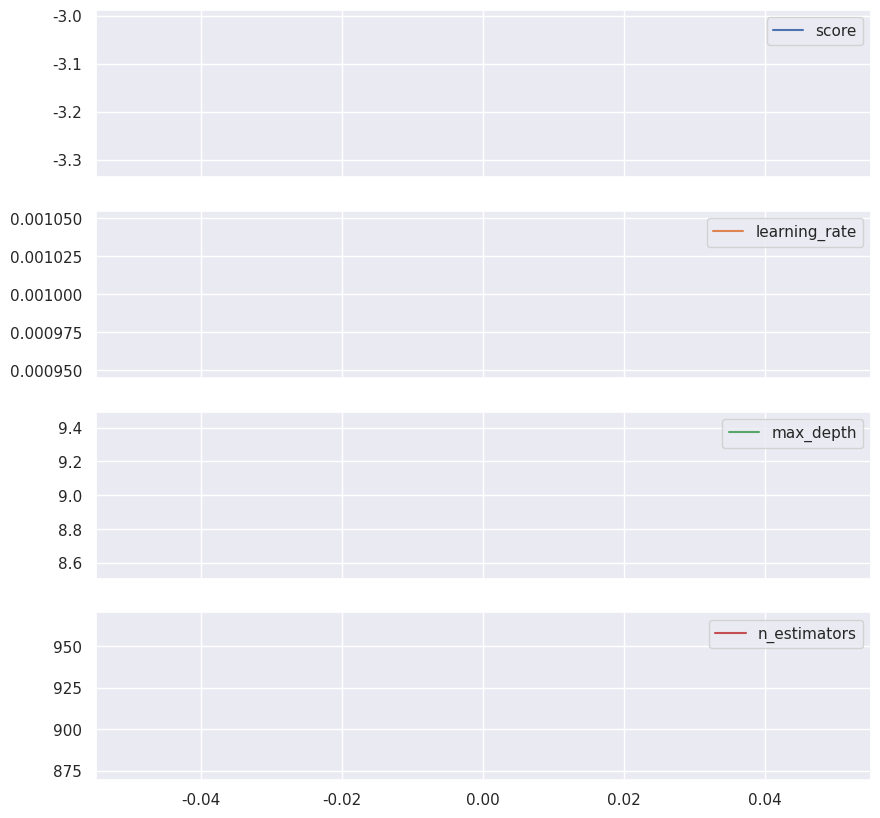

In [33]:
rs_results_df=pd.DataFrame(np.transpose([rs1.cv_results_['mean_test_score'],
                                         rs1.cv_results_['param_learning_rate'].data,
                                         rs1.cv_results_['param_max_depth'].data,
                                         rs1.cv_results_['param_n_estimators'].data]),
                           columns=['score', 'learning_rate', 'max_depth', 'n_estimators'])
rs_results_df.plot(subplots=True,figsize=(10, 10))

In [34]:
best_params['random_state'] = 42

# best 모델 인스턴스 생성(정의)
xgb_model2 = XGBRegressor(**best_params)

In [35]:
seed_everything(42)
n_iter = 0
rmse_lst = []

for train_index, valid_index in skf.split(train_features, train_target):
  n_iter += 1
  # 학습용, 검증용 데이터 구성
  train_x, valid_x = train_features.iloc[train_index], train_features.iloc[valid_index]
  train_y, valid_y = train_target.iloc[train_index], train_target.iloc[valid_index]

  # 학습
  xgb_model2.fit(train_x, train_y)
  valid_pred = xgb_model2.predict(valid_x) # 예측값

  # 평가
  rmse = mean_squared_error(valid_y, valid_pred, squared=False)
  rmse_lst.append(rmse)
  print(f'{n_iter} 번째 Stratified K-Fold RMSE: {rmse}')

# 최종 평가
print('-'*50)
print(f'교차 검증 RMSE: {np.mean(rmse_lst)}')

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=7.
  warnings.warn(


1 번째 Stratified K-Fold RMSE: 3.270393228185615
2 번째 Stratified K-Fold RMSE: 3.1504816832129663
3 번째 Stratified K-Fold RMSE: 3.192570684427172
4 번째 Stratified K-Fold RMSE: 3.0818147472673743
5 번째 Stratified K-Fold RMSE: 3.143845252210046
6 번째 Stratified K-Fold RMSE: 3.1218236368965857
7 번째 Stratified K-Fold RMSE: 3.244549226387445
--------------------------------------------------
교차 검증 RMSE: 3.1722112083696006


## Light GBM

### model 0

In [36]:
from lightgbm import LGBMRegressor, plot_importance
from sklearn.metrics import mean_squared_error

In [37]:
seed_everything(42)
hp= {
    'objective': 'regression',
    'boosting_type': 'gbdt',
    'metric': 'rmse',  # 회귀 모델의 성능 측정 메트릭 (Root Mean Squared Error)
    'num_leaves': 31,
    'learning_rate': 0.05,
    'verbose' : -1
}
lgb_model0 = LGBMRegressor(**hp)
n_iter = 0
accuracy_lst = []
rmse_lst = []
for train_index, valid_index in skf.split(train_features, train_target):
  n_iter += 1
  # 학습용, 검증용 데이터 구성
  tr_x, valid_x = train_features.iloc[train_index], train_features.iloc[valid_index]
  tr_y, valid_y = train_target.iloc[train_index], train_target.iloc[valid_index]

  # 학습
  lgb_model0.fit(tr_x, tr_y)
  valid_pred = lgb_model0.predict(valid_x) # 예측값

  # 평가
  rmse = mean_squared_error(valid_y, valid_pred, squared=False)
  rmse_lst.append(rmse)
  print(f'{n_iter} 번째 Stratified K-Fold RMSE: {rmse}')

# 최종 평가
print('-'*50)
print(f'교차 검증 RMSE: {np.mean(rmse_lst)}')

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=7.
  warnings.warn(


1 번째 Stratified K-Fold RMSE: 3.264234897576132
2 번째 Stratified K-Fold RMSE: 3.14011733177817
3 번째 Stratified K-Fold RMSE: 3.17881030547527
4 번째 Stratified K-Fold RMSE: 3.067139960909581
5 번째 Stratified K-Fold RMSE: 3.1303785551942993
6 번째 Stratified K-Fold RMSE: 3.1048389532170066
7 번째 Stratified K-Fold RMSE: 3.229995328825504
--------------------------------------------------
교차 검증 RMSE: 3.15935933328228


In [38]:
lgb_model0 = LGBMRegressor(**hp)
n_iter=3 # 몇번 hp조합을 찾을 것인가?
scoring = 'neg_root_mean_squared_error' # 어떤 평가지표를 사용할 것인가?
hp={
    "max_depth" : np.linspace(2,12,8,dtype = int), # 깊이
    "n_estimators" : np.linspace(1000,2000,200, dtype = int), # 부스팅 단계수
    "learning_rate" : np.logspace(-3, -0.8, 20)
}

# HPO 인스턴스 생성
rs1=RandomizedSearchCV(lgb_model0, hp, scoring=scoring, n_iter=n_iter, n_jobs=-1, cv=skf, verbose=3)
# 학습 (best hp 조합 찾기)
rs1.fit(train_features, train_target)

# 학습 결과 (best hp 조합일 때,)
rs1.best_score_

Fitting 7 folds for each of 3 candidates, totalling 21 fits


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=7.
  warnings.warn(


-3.1633412751699224

In [39]:
best_params = rs1.best_params_
best_params

{'n_estimators': 1301, 'max_depth': 7, 'learning_rate': 0.001}

In [40]:
best_params.keys

<function dict.keys>

In [41]:
hp= {
    'objective': 'regression',
    'boosting_type': 'gbdt',
    'metric': 'rmse',  # 회귀 모델의 성능 측정 메트릭 (Root Mean Squared Error)
    'num_leaves': 31,
    #'learning_rate': 0.05,
    'verbose' : -1,
    'n_estimators': 1473, 'max_depth': 7, 'learning_rate': 0.032008340465997674
}
lgb_model0 = LGBMRegressor(**hp)
n_iter = 0
accuracy_lst = []
rmse_lst = []

for train_index, valid_index in skf.split(train_features, train_target):
  n_iter += 1
  # 학습용, 검증용 데이터 구성
  tr_x, valid_x = train_features.iloc[train_index], train_features.iloc[valid_index]
  tr_y, valid_y = train_target.iloc[train_index], train_target.iloc[valid_index]

  # 학습
  lgb_model0.fit(tr_x, tr_y)
  valid_pred = lgb_model0.predict(valid_x) # 예측값

  # 평가
  rmse = mean_squared_error(valid_y, valid_pred, squared=False)
  rmse_lst.append(rmse)
  print(f'{n_iter} 번째 Stratified K-Fold RMSE: {rmse}')

# 최종 평가
print('-'*50)
print(f'교차 검증 RMSE: {np.mean(rmse_lst)}')

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=7.
  warnings.warn(


1 번째 Stratified K-Fold RMSE: 3.2997811345960075
2 번째 Stratified K-Fold RMSE: 3.195462839548345
3 번째 Stratified K-Fold RMSE: 3.225993610218349
4 번째 Stratified K-Fold RMSE: 3.1028295570157503
5 번째 Stratified K-Fold RMSE: 3.1757593481111157
6 번째 Stratified K-Fold RMSE: 3.1656796500028865
7 번째 Stratified K-Fold RMSE: 3.2704952090086246
--------------------------------------------------
교차 검증 RMSE: 3.205143049785869


### model 1

In [42]:
hp = {
    "random_state" : 42,
    'verbose' : -1
}
lgb_model1 = LGBMRegressor(**hp)
n_iter = 0
accuracy_lst = []

for train_index, valid_index in skf.split(train_features, train_target):
  n_iter += 1
  # 학습용, 검증용 데이터 구성
  train_x, valid_x = train_features.iloc[train_index], train_features.iloc[valid_index]
  train_y, valid_y = train_target.iloc[train_index], train_target.iloc[valid_index]

  # 학습
  lgb_model1.fit(train_x, train_y)
  valid_pred = lgb_model1.predict(valid_x) # 예측값

  # 평가
  rmse = mean_squared_error(valid_y, valid_pred, squared=False)
  rmse_lst.append(rmse)
  print(f'{n_iter} 번째 Stratified K-Fold RMSE: {rmse}')

# 최종 평가
print('-'*50)
print(f'교차 검증 RMSE: {np.mean(rmse_lst)}')

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=7.
  warnings.warn(


1 번째 Stratified K-Fold RMSE: 3.27185714578914
2 번째 Stratified K-Fold RMSE: 3.14790932462572
3 번째 Stratified K-Fold RMSE: 3.1837677118151215
4 번째 Stratified K-Fold RMSE: 3.072243937792985
5 번째 Stratified K-Fold RMSE: 3.140393943879277
6 번째 Stratified K-Fold RMSE: 3.11386793035757
7 번째 Stratified K-Fold RMSE: 3.233790055939459
--------------------------------------------------
교차 검증 RMSE: 3.1857022427643105


### model 2

In [43]:
hp = {
    "random_state" : 42,
    "verbose": -1, # 로그
}
lgb_model2 = LGBMRegressor(**hp)

In [44]:
n_iter=3 # 몇번 hp조합을 찾을 것인가?
scoring = 'neg_root_mean_squared_error' # 어떤 평가지표를 사용할 것인가?
hp={
    "max_depth" : np.linspace(5,12,8,dtype = int), # 깊이
    "n_estimators" : np.linspace(800,1200,100, dtype = int), # 부스팅 단계수
    "learning_rate" : np.logspace(-3, -1, 3)
}

# HPO 인스턴스 생성
rs1=RandomizedSearchCV(lgb_model2, hp, scoring=scoring, n_iter=n_iter, n_jobs=-1, cv=skf, verbose=False)
# 학습 (best hp 조합 찾기)
rs1.fit(train_x, train_y)

# 학습 결과 (best hp 조합일 때,)
rs1.best_score_

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=7.
  warnings.warn(


-3.1489189769982966

In [45]:
best_params = rs1.best_params_
best_params

{'n_estimators': 921, 'max_depth': 8, 'learning_rate': 0.01}

array([<Axes: >, <Axes: >, <Axes: >, <Axes: >], dtype=object)

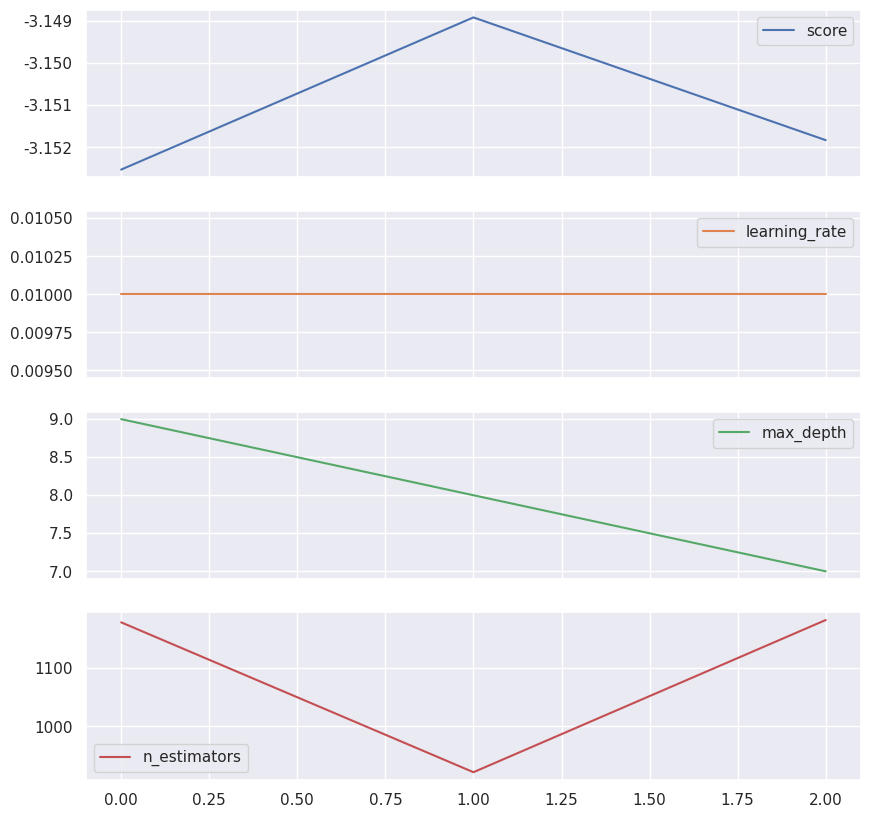

In [46]:
rs_results_df=pd.DataFrame(np.transpose([rs1.cv_results_['mean_test_score'],
                                         rs1.cv_results_['param_learning_rate'].data,
                                         rs1.cv_results_['param_max_depth'].data,
                                         rs1.cv_results_['param_n_estimators'].data]),
                           columns=['score', 'learning_rate', 'max_depth', 'n_estimators'])
rs_results_df.plot(subplots=True,figsize=(10, 10))

In [47]:
best_params['random_state'] = 42
best_params['verbose'] = -1

# best 모델 인스턴스 생성(정의)
lgb_model2 = LGBMRegressor(**best_params)

In [48]:
n_iter = 0
accuracy_lst = []

for train_index, valid_index in skf.split(train_features, train_target):
  n_iter += 1
  # 학습용, 검증용 데이터 구성
  train_x, valid_x = train_features.iloc[train_index], train_features.iloc[valid_index]
  train_y, valid_y = train_target.iloc[train_index], train_target.iloc[valid_index]

  # 학습
  lgb_model2.fit(train_x, train_y)
  valid_pred = lgb_model2.predict(valid_x) # 예측값

  # 평가
  rmse = mean_squared_error(valid_y, valid_pred, squared=False)
  rmse_lst.append(rmse)
  print(f'{n_iter} 번째 Stratified K-Fold RMSE: {rmse}')

# 최종 평가
print('-'*50)
print(f'교차 검증 RMSE: {np.mean(rmse_lst)}')

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=7.
  warnings.warn(


1 번째 Stratified K-Fold RMSE: 3.2668971420265938
2 번째 Stratified K-Fold RMSE: 3.147952334656529
3 번째 Stratified K-Fold RMSE: 3.1781897588402686
4 번째 Stratified K-Fold RMSE: 3.064828639661421
5 번째 Stratified K-Fold RMSE: 3.1359006647542946
6 번째 Stratified K-Fold RMSE: 3.1098892328629213
7 번째 Stratified K-Fold RMSE: 3.2320135991379075
--------------------------------------------------
교차 검증 RMSE: 3.1778810843162044


/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 44592 (\N{HANGUL SYLLABLE GI}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 49345 (\N{HANGUL SYLLABLE SANG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 53468 (\N{HANGUL SYLLABLE TAE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 45432 (\N{HANGUL SYLLABLE NO}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 47732 (\N{HANGUL SYLLABLE MYEON}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages

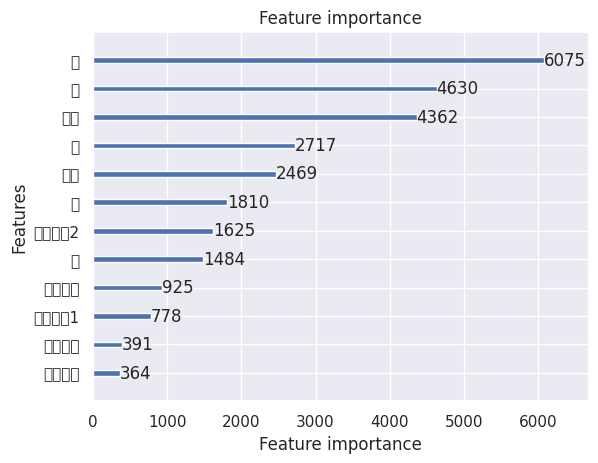

In [49]:
plot_importance(lgb_model2)
plt.show()

## Catboost

### model 1

In [50]:
from catboost import CatBoostRegressor

In [51]:
hp = {
    "random_state" : 42,
    "verbose" : 0 # 부스팅 단계 출력 안보이게 하기
}
cat_model1 = CatBoostRegressor(**hp)
n_iter = 0
accuracy_lst = []

for train_index, valid_index in skf.split(train_features, train_target):
  n_iter += 1
  # 학습용, 검증용 데이터 구성
  train_x, valid_x = train_features.iloc[train_index], train_features.iloc[valid_index]
  train_y, valid_y = train_target.iloc[train_index], train_target.iloc[valid_index]

  # 학습
  cat_model1.fit(train_x, train_y)
  valid_pred = cat_model1.predict(valid_x) # 예측값

  # 평가
  rmse = mean_squared_error(valid_y, valid_pred, squared=False)
  rmse_lst.append(rmse)
  print(f'{n_iter} 번째 Stratified K-Fold RMSE: {rmse}')

# 최종 평가
print('-'*50)
print(f'교차 검증 RMSE: {np.mean(rmse_lst)}')

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=7.
  warnings.warn(


1 번째 Stratified K-Fold RMSE: 3.2892909436056805
2 번째 Stratified K-Fold RMSE: 3.1732422154155766
3 번째 Stratified K-Fold RMSE: 3.2028618744231343
4 번째 Stratified K-Fold RMSE: 3.082776454467686
5 번째 Stratified K-Fold RMSE: 3.155618287807553
6 번째 Stratified K-Fold RMSE: 3.1375335046832484
7 번째 Stratified K-Fold RMSE: 3.2511626679123347
--------------------------------------------------
교차 검증 RMSE: 3.1795710256769825


### model 2

In [52]:
hp = {
    "random_state" : 42,
    "verbose": 0, # 로그
}
cat_model2 = CatBoostRegressor(**hp)

In [53]:
n_iter=3 # 몇번 hp조합을 찾을 것인가?
scoring = 'neg_root_mean_squared_error' # 어떤 평가지표를 사용할 것인가?
hp={
    "max_depth" : np.linspace(5,12,8,dtype = int), # 깊이
    "n_estimators" : np.linspace(100,500,100, dtype = int), # 부스팅 단계수
    "learning_rate" : np.logspace(-3, -1, 3)
}

# HPO 인스턴스 생성
rs1=RandomizedSearchCV(cat_model2, hp, scoring=scoring, n_iter=n_iter, n_jobs=-1, cv=skf, verbose=False)
# 학습 (best hp 조합 찾기)
rs1.fit(train_x, train_y)

# 학습 결과 (best hp 조합일 때,)
rs1.best_score_

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=7.
  warnings.warn(


-3.1493000050955477

In [54]:
best_params = rs1.best_params_
best_params

{'n_estimators': 253, 'max_depth': 5, 'learning_rate': 0.1}

array([<Axes: >, <Axes: >, <Axes: >, <Axes: >], dtype=object)

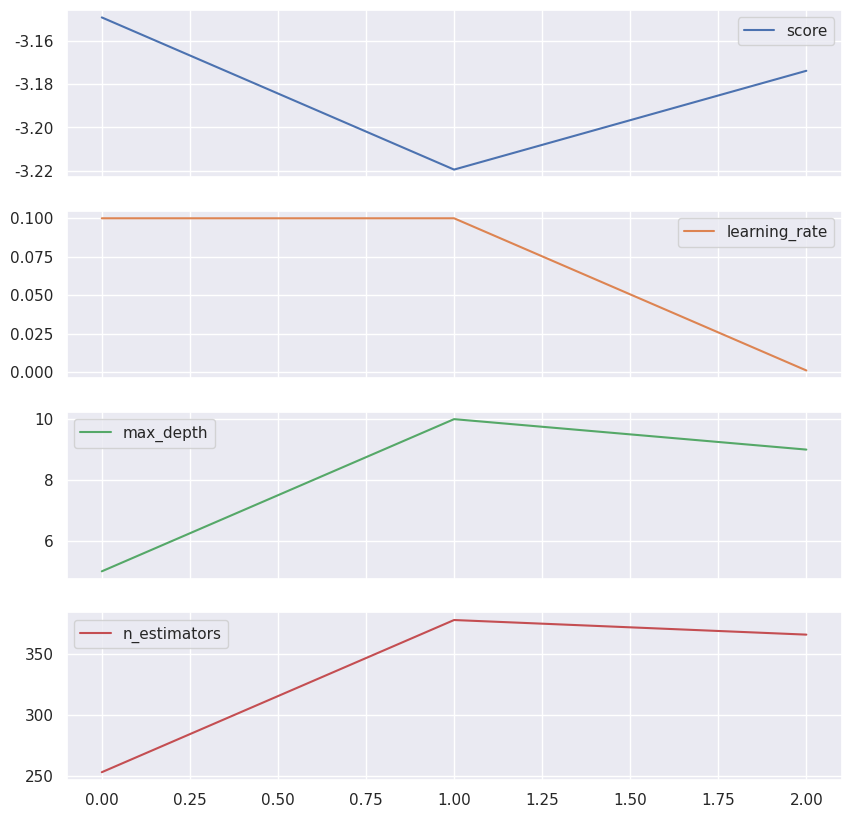

In [55]:
rs_results_df=pd.DataFrame(np.transpose([rs1.cv_results_['mean_test_score'],
                                         rs1.cv_results_['param_learning_rate'].data,
                                         rs1.cv_results_['param_max_depth'].data,
                                         rs1.cv_results_['param_n_estimators'].data]),
                           columns=['score', 'learning_rate', 'max_depth', 'n_estimators'])
rs_results_df.plot(subplots=True,figsize=(10, 10))

In [56]:
best_params['random_state'] = 42
best_params['verbose'] = 0

# best 모델 인스턴스 생성(정의)
cat_model2 = CatBoostRegressor(**best_params)

In [57]:
n_iter = 0
accuracy_lst = []

for train_index, valid_index in skf.split(train_features, train_target):
  n_iter += 1
  # 학습용, 검증용 데이터 구성
  train_x, valid_x = train_features.iloc[train_index], train_features.iloc[valid_index]
  train_y, valid_y = train_target.iloc[train_index], train_target.iloc[valid_index]

  # 학습
  cat_model2.fit(train_x, train_y)
  valid_pred = cat_model2.predict(valid_x) # 예측값

  # 평가
  rmse = mean_squared_error(valid_y, valid_pred, squared=False)
  rmse_lst.append(rmse)
  print(f'{n_iter} 번째 Stratified K-Fold RMSE: {rmse}')

# 최종 평가
print('-'*50)
print(f'교차 검증 RMSE: {np.mean(rmse_lst)}')

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=7.
  warnings.warn(


1 번째 Stratified K-Fold RMSE: 3.2648667815121786
2 번째 Stratified K-Fold RMSE: 3.142002636974
3 번째 Stratified K-Fold RMSE: 3.174051434982104
4 번째 Stratified K-Fold RMSE: 3.0609255177647805
5 번째 Stratified K-Fold RMSE: 3.133235376900116
6 번째 Stratified K-Fold RMSE: 3.1057241363976025
7 번째 Stratified K-Fold RMSE: 3.2268502351368293
--------------------------------------------------
교차 검증 RMSE: 3.175304138246374


Text(0.5, 1.0, 'Feature Importance')

/usr/local/lib/python3.10/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 46020 (\N{HANGUL SYLLABLE DO}) missing from current font.
  func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 49884 (\N{HANGUL SYLLABLE SI}) missing from current font.
  func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 44592 (\N{HANGUL SYLLABLE GI}) missing from current font.
  func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 49345 (\N{HANGUL SYLLABLE SANG}) missing from current font.
  func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 53468 (\N{HANGUL SYLLABLE TAE}) missing from current font.
  func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 45432 (\N{HANGUL SYLLABLE NO}) missing from current font.
  func(*args,

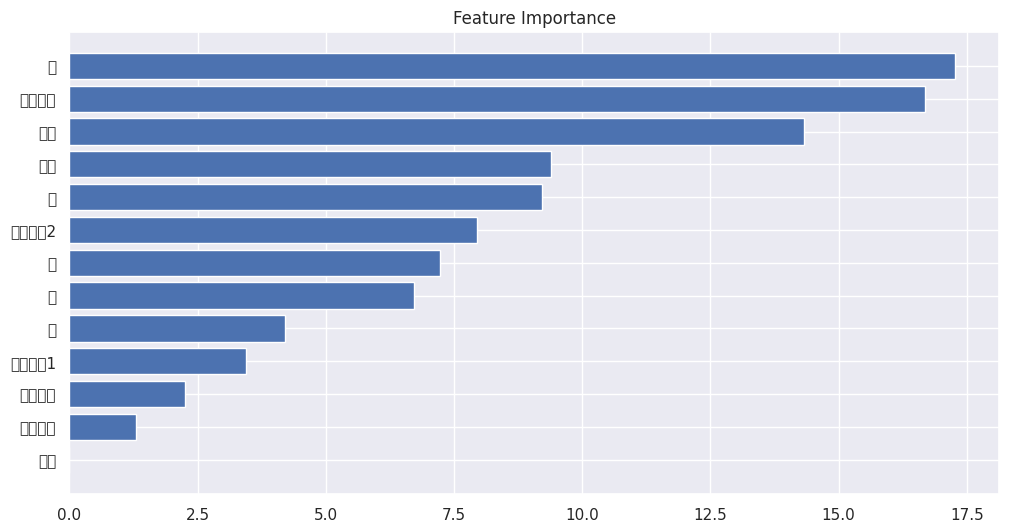

In [58]:
feature_importance = cat_model2.feature_importances_
sorted_idx = np.argsort(feature_importance)

fig = plt.figure(figsize=(12, 6))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
# plt.yticks(range(len(sorted_idx)), np.array(range(len(train_x)))[sorted_idx])
# 변수명이 있다면, 아래와 같이...
plt.yticks(range(len(sorted_idx)), np.array(train_x.columns)[sorted_idx])
plt.title('Feature Importance')

## RandomForest

### model 1

In [59]:
from sklearn.ensemble import RandomForestRegressor

In [60]:
rfr_hp = {
    "random_state": 42,
    "verbose": 0  # 부스팅 단계 출력 안보이게 하기
}
rfr_model1 = RandomForestRegressor(**rfr_hp)  # RandomForestRegressor로 모델 변경
n_iter = 0
rmse_lst = []

for train_index, valid_index in skf.split(train_features, train_target):
    n_iter += 1
    # 학습용, 검증용 데이터 구성
    train_x, valid_x = train_features.iloc[train_index], train_features.iloc[valid_index]
    train_y, valid_y = train_target.iloc[train_index], train_target.iloc[valid_index]

    # 학습
    rfr_model1.fit(train_x, train_y)
    valid_pred = rfr_model1.predict(valid_x)  # 예측값

    # 평가
    rmse = mean_squared_error(valid_y, valid_pred, squared=False)
    rmse_lst.append(rmse)
    print(f'{n_iter} 번째 Stratified K-Fold RMSE: {rmse}')

# 최종 평가
print('-' * 50)
print(f'교차 검증 RMSE: {np.mean(rmse_lst)}')

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=7.
  warnings.warn(


1 번째 Stratified K-Fold RMSE: 3.3775449530981754
2 번째 Stratified K-Fold RMSE: 3.2598971277794124
3 번째 Stratified K-Fold RMSE: 3.310969020730664
4 번째 Stratified K-Fold RMSE: 3.2094462407247417
5 번째 Stratified K-Fold RMSE: 3.2378724903234795
6 번째 Stratified K-Fold RMSE: 3.257587087425963
7 번째 Stratified K-Fold RMSE: 3.351341632844847
--------------------------------------------------
교차 검증 RMSE: 3.286379793275326


### model 2

In [61]:
rfr_hp2 = {
    "random_state" : 42,
    "verbose": 0, # 로그
}
rfr_model2 = RandomForestRegressor(**rfr_hp2)

In [62]:
n_iter=5 # 몇번 hp조합을 찾을 것인가?
scoring = 'neg_root_mean_squared_error' # 어떤 평가지표를 사용할 것인가?
rfr_hp2={
    "max_depth" : np.linspace(5,12,8,dtype = int), # 깊이
    "n_estimators" : np.linspace(100,500,100, dtype = int), # 부스팅 단계수
}

# HPO 인스턴스 생성
rs1 = RandomizedSearchCV(RandomForestRegressor(), rfr_hp2, scoring=scoring, n_iter=n_iter, n_jobs=-1, cv=skf, verbose=3)
# 학습 (best hp 조합 찾기)
rs1.fit(train_x, train_y)

# 학습 결과 (best hp 조합일 때,)
rs1.best_score_

Fitting 7 folds for each of 5 candidates, totalling 35 fits


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=7.
  warnings.warn(


-3.1507765248102375

In [63]:
rfr_best_params = rs1.best_params_
rfr_best_params

{'n_estimators': 156, 'max_depth': 7}

array([<Axes: >, <Axes: >, <Axes: >], dtype=object)

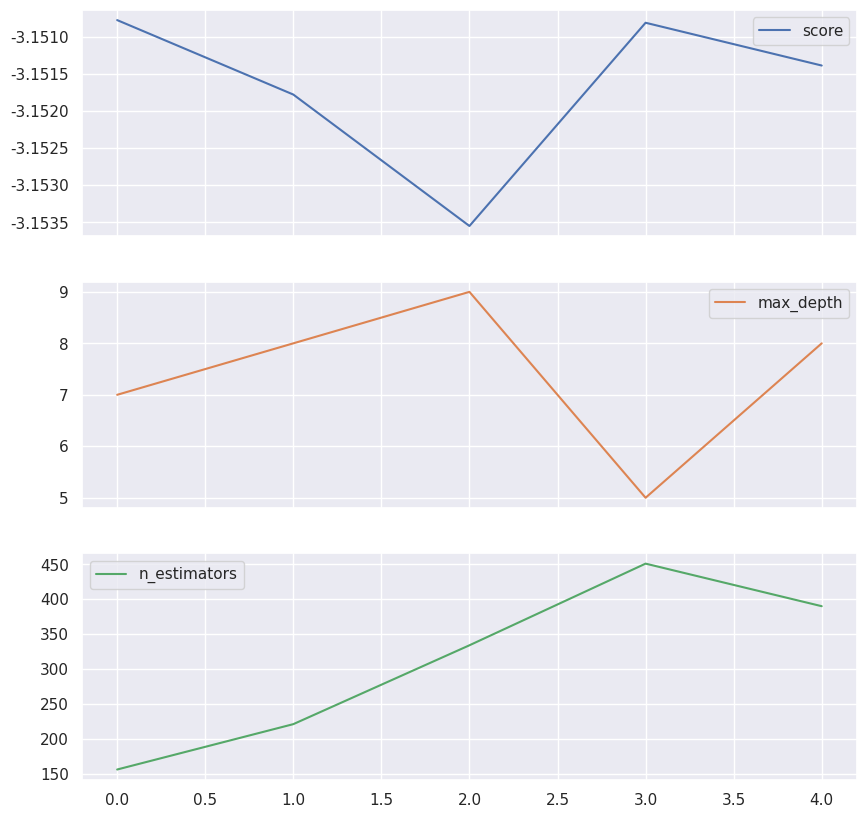

In [64]:
rs_results_df=pd.DataFrame(np.transpose([rs1.cv_results_['mean_test_score'],
                                         rs1.cv_results_['param_max_depth'].data,
                                         rs1.cv_results_['param_n_estimators'].data]),
                           columns=['score', 'max_depth', 'n_estimators'])
rs_results_df.plot(subplots=True,figsize=(10, 10))

In [65]:
rfr_best_params['random_state'] = 42
rfr_best_params['verbose'] = 0

# best 모델 인스턴스 생성(정의)
rfr_model2 = RandomForestRegressor(**rfr_best_params)

In [66]:
n_iter = 0
accuracy_lst = []

for train_index, valid_index in skf.split(train_features, train_target):
  n_iter += 1
  # 학습용, 검증용 데이터 구성
  train_x, valid_x = train_features.iloc[train_index], train_features.iloc[valid_index]
  train_y, valid_y = train_target.iloc[train_index], train_target.iloc[valid_index]

  # 학습
  rfr_model2.fit(train_x, train_y)
  valid_pred = rfr_model2.predict(valid_x) # 예측값

  # 평가
  rmse = mean_squared_error(valid_y, valid_pred, squared=False)
  rmse_lst.append(rmse)
  print(f'{n_iter} 번째 Stratified K-Fold RMSE: {rmse}')

# 최종 평가
print('-'*50)
print(f'교차 검증 RMSE: {np.mean(rmse_lst)}')

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=7.
  warnings.warn(


1 번째 Stratified K-Fold RMSE: 3.266166275062655
2 번째 Stratified K-Fold RMSE: 3.1411135880619296
3 번째 Stratified K-Fold RMSE: 3.184618472367075
4 번째 Stratified K-Fold RMSE: 3.0706601447510042
5 번째 Stratified K-Fold RMSE: 3.134408346835371
6 번째 Stratified K-Fold RMSE: 3.1085169509517003
7 번째 Stratified K-Fold RMSE: 3.235224804086873
--------------------------------------------------
교차 검증 RMSE: 3.224669081074564


## MLPRegressor

### model 1

In [67]:
from sklearn.neural_network import MLPRegressor

# seed_everything(42)
np.random.seed(42)

n_iter = 0
rmse_lst = []

for train_index, valid_index in skf.split(train_features, train_target):
    n_iter += 1
    # 학습용, 검증용 데이터 구성
    train_x, valid_x = train_features.iloc[train_index], train_features.iloc[valid_index]
    train_y, valid_y = train_target.iloc[train_index], train_target.iloc[valid_index]

    # MLPRegressor 모델 정의
    mlp_model = MLPRegressor(random_state=42)

    # 학습
    mlp_model.fit(train_x, train_y)
    valid_pred = mlp_model.predict(valid_x)  # 예측값

    # 평가
    rmse = mean_squared_error(valid_y, valid_pred, squared=False)
    rmse_lst.append(rmse)
    print(f'{n_iter} 번째 Stratified K-Fold RMSE: {rmse}')

# 최종 평가
print('-'*50)
print(f'교차 검증 RMSE: {np.mean(rmse_lst)}')


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=7.
  warnings.warn(


1 번째 Stratified K-Fold RMSE: 3.436281077834364
2 번째 Stratified K-Fold RMSE: 3.551790819329923
3 번째 Stratified K-Fold RMSE: 3.2138015662515276
4 번째 Stratified K-Fold RMSE: 3.107455976970378
5 번째 Stratified K-Fold RMSE: 3.2674964431869817
6 번째 Stratified K-Fold RMSE: 3.1374291764395825
7 번째 Stratified K-Fold RMSE: 3.459404680903057
--------------------------------------------------
교차 검증 RMSE: 3.3105228201308305


### model 2

In [68]:
from sklearn.model_selection import RandomizedSearchCV

# 하이퍼파라미터 분포 설정
param_dist = {
    'hidden_layer_sizes': [(50, ), (100, ), (50, 50), (100, 50)],
    'activation': ['identity', 'logistic', 'tanh', 'relu'],
    'solver': ['lbfgs', 'sgd', 'adam'],
    'alpha': [0.0001, 0.001, 0.01, 0.1],
    'learning_rate': ['constant', 'invscaling', 'adaptive'],
    'max_iter': [100, 200, 300],
    'random_state': [42]
}

# MLPRegressor 모델 정의
mlp_model2 = MLPRegressor()

# RandomizedSearchCV 인스턴스 생성
random_search = RandomizedSearchCV(mlp_model2, param_distributions=param_dist, scoring='neg_root_mean_squared_error', n_iter=10, cv=skf, n_jobs=-1, random_state=42)

# 학습
random_search.fit(train_features, train_target)

# 최적의 하이퍼파라미터 및 모델 출력
best_params = random_search.best_params_
print("Best Parameters:", best_params)

# 최적의 모델을 사용하여 평가
mlp_model2 = random_search.best_estimator_

n_iter = 0
rmse_lst = []

for train_index, valid_index in skf.split(train_features, train_target):
    n_iter += 1
    # 학습용, 검증용 데이터 구성
    train_x, valid_x = train_features.iloc[train_index], train_features.iloc[valid_index]
    train_y, valid_y = train_target.iloc[train_index], train_target.iloc[valid_index]

    # 예측
    valid_pred = mlp_model2.predict(valid_x)

    # 평가
    rmse = mean_squared_error(valid_y, valid_pred, squared=False)
    rmse_lst.append(rmse)
    print(f'{n_iter} 번째 Stratified K-Fold RMSE: {rmse}')

# 최종 평가
print('-'*50)
print(f'교차 검증 RMSE: {np.mean(rmse_lst)}')


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=7.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
7 fits failed out of a total of 70.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
7 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py", line 749, in fit
    return 

Best Parameters: {'solver': 'lbfgs', 'random_state': 42, 'max_iter': 100, 'learning_rate': 'adaptive', 'hidden_layer_sizes': (50,), 'alpha': 0.1, 'activation': 'relu'}
1 번째 Stratified K-Fold RMSE: 3.316083956054468
2 번째 Stratified K-Fold RMSE: 3.1764398581805073
3 번째 Stratified K-Fold RMSE: 3.2355523789290643
4 번째 Stratified K-Fold RMSE: 3.119079754904594
5 번째 Stratified K-Fold RMSE: 3.1891349706592846
6 번째 Stratified K-Fold RMSE: 3.159221127461915
7 번째 Stratified K-Fold RMSE: 3.286101535513825
--------------------------------------------------
교차 검증 RMSE: 3.2116590831005225


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=7.
  warnings.warn(


## KNeighborsRegressor

### model 1

In [69]:
from sklearn.neighbors import KNeighborsRegressor

# seed_everything(42)
np.random.seed(42)

n_iter = 0
rmse_lst = []

for train_index, valid_index in skf.split(train_features, train_target):
    n_iter += 1
    # 학습용, 검증용 데이터 구성
    train_x, valid_x = train_features.iloc[train_index], train_features.iloc[valid_index]
    train_y, valid_y = train_target.iloc[train_index], train_target.iloc[valid_index]

    # KNeighborsRegressor 모델 정의
    knn_model = KNeighborsRegressor()

    # 학습
    knn_model.fit(train_x, train_y)
    valid_pred = knn_model.predict(valid_x)  # 예측값

    # 평가
    rmse = mean_squared_error(valid_y, valid_pred, squared=False)
    rmse_lst.append(rmse)
    print(f'{n_iter} 번째 Stratified K-Fold RMSE: {rmse}')

# 최종 평가
print('-'*50)
print(f'교차 검증 RMSE: {np.mean(rmse_lst)}')


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=7.
  warnings.warn(


1 번째 Stratified K-Fold RMSE: 3.5665951288118567
2 번째 Stratified K-Fold RMSE: 3.430429405944864
3 번째 Stratified K-Fold RMSE: 3.523454344497644
4 번째 Stratified K-Fold RMSE: 3.420313385495804
5 번째 Stratified K-Fold RMSE: 3.4635515682955393
6 번째 Stratified K-Fold RMSE: 3.4743731808265093
7 번째 Stratified K-Fold RMSE: 3.54739460499718
--------------------------------------------------
교차 검증 RMSE: 3.489444516981343


### model 2

In [70]:
from sklearn.model_selection import GridSearchCV

# 하이퍼파라미터 그리드 설정
param_grid = {
    'n_neighbors': [3, 5, 7, 9],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}

# KNeighborsRegressor 모델 정의
knn_model2 = KNeighborsRegressor()

# GridSearchCV 인스턴스 생성
grid_search = GridSearchCV(knn_model2, param_grid, scoring='neg_root_mean_squared_error', cv=skf, n_jobs=-1)

# 학습
grid_search.fit(train_features, train_target)

# 최적의 하이퍼파라미터 및 모델 출력
best_params = grid_search.best_params_
print("Best Parameters:", best_params)

# 최적의 모델을 사용하여 평가
knn_model2 = grid_search.best_estimator_

n_iter = 0
rmse_lst = []

for train_index, valid_index in skf.split(train_features, train_target):
    n_iter += 1
    # 학습용, 검증용 데이터 구성
    train_x, valid_x = train_features.iloc[train_index], train_features.iloc[valid_index]
    train_y, valid_y = train_target.iloc[train_index], train_target.iloc[valid_index]

    # 예측
    valid_pred = knn_model2.predict(valid_x)

    # 평가
    rmse = mean_squared_error(valid_y, valid_pred, squared=False)
    rmse_lst.append(rmse)
    print(f'{n_iter} 번째 Stratified K-Fold RMSE: {rmse}')

# 최종 평가
print('-'*50)
print(f'교차 검증 RMSE: {np.mean(rmse_lst)}')


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=7.
  warnings.warn(


Best Parameters: {'metric': 'manhattan', 'n_neighbors': 9, 'weights': 'uniform'}


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=7.
  warnings.warn(


1 번째 Stratified K-Fold RMSE: 3.0719595333335783
2 번째 Stratified K-Fold RMSE: 2.9623062010596404
3 번째 Stratified K-Fold RMSE: 3.0362245747130188
4 번째 Stratified K-Fold RMSE: 2.9501759053890035
5 번째 Stratified K-Fold RMSE: 2.972896578342524
6 번째 Stratified K-Fold RMSE: 2.9814155535922606
7 번째 Stratified K-Fold RMSE: 3.067911896428561
--------------------------------------------------
교차 검증 RMSE: 3.006127177551227


In [71]:
knn_model2

KNeighborsRegressor(metric='manhattan', n_neighbors=9)

In [72]:
pred = knn_model2.predict(train_x)

# RMSE 계산
rmse = np.sqrt(mean_squared_error(train_y, pred))
print(f'RMSE: {rmse}')

RMSE: 2.996148419429313


In [73]:
pred_df = pd.DataFrame(pred, columns=['ECLO'])

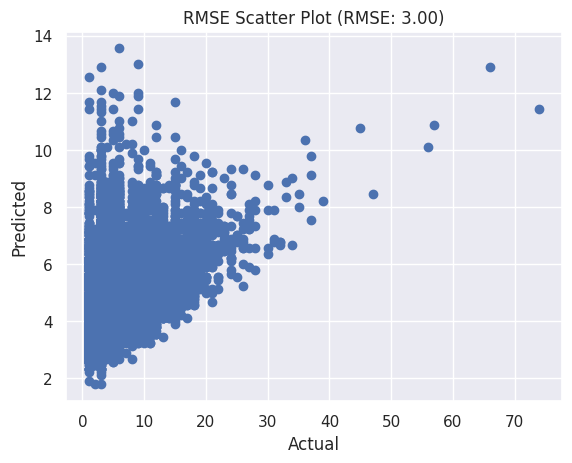

In [74]:
import matplotlib.pyplot as plt

# train_y와 pred의 RMSE를 계산
rmse = np.sqrt(mean_squared_error(train_y, pred))

# 산포도 그래프 생성
plt.scatter(train_y, pred)

# 그래프에 제목과 x축, y축 레이블 추가
plt.title(f'RMSE Scatter Plot (RMSE: {rmse:.2f})')
plt.xlabel('Actual')
plt.ylabel('Predicted')

# 그래프 표시
plt.show()

In [75]:
prediction =  knn_model2.predict(test_features)

In [76]:
baseline_submission = sample_submission.copy()
baseline_submission['ECLO'] = prediction
baseline_submission

,ID,ECLO
0,ACCIDENT_39609,8.666667
1,ACCIDENT_39610,6.222222
2,ACCIDENT_39611,6.333333
3,ACCIDENT_39612,3.555556
4,ACCIDENT_39613,3.333333
...,...,...
10958,ACCIDENT_50567,4.777778
10959,ACCIDENT_50568,5.555556
10960,ACCIDENT_50569,4.888889
10961,ACCIDENT_50570,7.666667


In [77]:
baseline_submission.to_csv('KNN_Submission.csv', index=False)

## train_y, pred RMSE

In [78]:
rfr_model2

RandomForestRegressor(max_depth=7, n_estimators=156, random_state=42)

In [79]:
pred = rfr_model2.predict(train_x)

# RMSE 계산
rmse = np.sqrt(mean_squared_error(train_y, pred))
print(f'RMSE: {rmse}')

RMSE: 3.1033471897814127


In [80]:
pred_df = pd.DataFrame(pred, columns=['ECLO'])

# 학습 평가

## 산포도

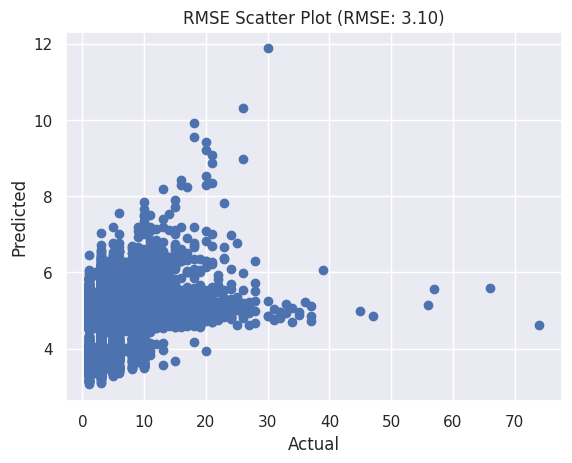

In [81]:
import matplotlib.pyplot as plt

# train_y와 pred의 RMSE를 계산
rmse = np.sqrt(mean_squared_error(train_y, pred))

# 산포도 그래프 생성
plt.scatter(train_y, pred)

# 그래프에 제목과 x축, y축 레이블 추가
plt.title(f'RMSE Scatter Plot (RMSE: {rmse:.2f})')
plt.xlabel('Actual')
plt.ylabel('Predicted')

# 그래프 표시
plt.show()

# Voting

In [87]:
from sklearn.ensemble import VotingRegressor

# Voting Regressor 정의
voting_reg = VotingRegressor(estimators=[
    ('xgb', xgb_model2),
    ('cat', cat_model2),
    ('lgb',lgb_model2),
    ('forest', rfr_model2),
    ('knn', knn_model2),
    ('MLP', mlp_model2),
])

n_iter = 0
rmse_lst = []

for train_index, valid_index in skf.split(train_features, train_target):
    n_iter += 1
    # 학습용, 검증용 데이터 구성
    train_x, valid_x = train_features.iloc[train_index], train_features.iloc[valid_index]
    train_y, valid_y = train_target.iloc[train_index], train_target.iloc[valid_index]

    # Voting Regressor 학습
    voting_reg.fit(train_x, train_y)

    # 검증 데이터에 대한 예측
    valid_pred = voting_reg.predict(valid_x)

    # 평가
    rmse = mean_squared_error(valid_y, valid_pred, squared=False)
    rmse_lst.append(rmse)
    print(f'{n_iter} 번째 Stratified K-Fold RMSE: {rmse}')

# 최종 평가
print('-'*50)
print(f'교차 검증 RMSE: {np.mean(rmse_lst)}')

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=7.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


1 번째 Stratified K-Fold RMSE: 3.2693020241181134


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


2 번째 Stratified K-Fold RMSE: 3.145393335940989


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


3 번째 Stratified K-Fold RMSE: 3.1914951187163867


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


4 번째 Stratified K-Fold RMSE: 3.078243745858863


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


5 번째 Stratified K-Fold RMSE: 3.1381596547944


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


6 번째 Stratified K-Fold RMSE: 3.114699682499117


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


7 번째 Stratified K-Fold RMSE: 3.2410912336629396
--------------------------------------------------
교차 검증 RMSE: 3.1683406850844014


In [88]:
voting_reg

VotingRegressor(estimators=[('xgb',
                             XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None, device=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, feature_types=None,
                                          gamma=None, grow_policy=None,
                                          importance_type=None,
                                          interaction_constraints=None,
                                          learning_rate...
                             LGBMRegressor(learning_rate=0.01, max_depth=8,
                                           n_estimators=921, random_state=42,
                                           verbose=-1)),
                            ('forest',
                             RandomForestRegressor(max_depth=7,
                                                   n_estimators=156,
                                                   random_state=42)),
                            ('knn',
                             KNeighborsRegressor(metric='manhattan',
                                                 n_neighbors=9)),
                            ('MLP',
                             MLPRegressor(alpha=0.1, hidden_layer_sizes=(50,),
                                          learning_rate='adaptive',
                                          max_iter=100, random_state=42,
                                          solver='lbfgs'))])

In [89]:
pred = voting_reg.predict(train_x)

# RMSE 계산
rmse = np.sqrt(mean_squared_error(train_y, pred))
print(f'RMSE: {rmse}')

RMSE: 3.042456240638539


In [90]:
pred_df = pd.DataFrame(pred, columns=['ECLO'])

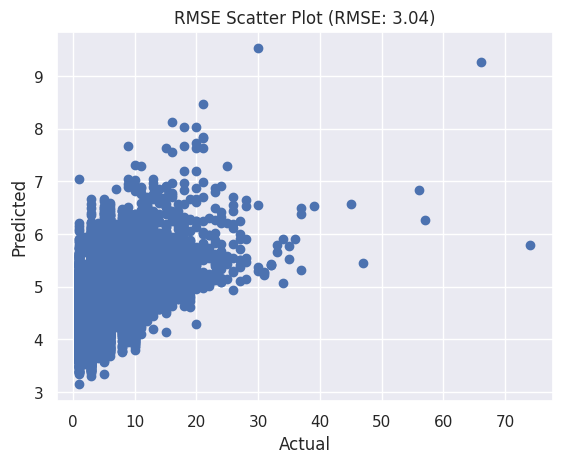

In [91]:
import matplotlib.pyplot as plt

# train_y와 pred의 RMSE를 계산
rmse = np.sqrt(mean_squared_error(train_y, pred))

# 산포도 그래프 생성
plt.scatter(train_y, pred)

# 그래프에 제목과 x축, y축 레이블 추가
plt.title(f'RMSE Scatter Plot (RMSE: {rmse:.2f})')
plt.xlabel('Actual')
plt.ylabel('Predicted')

# 그래프 표시
plt.show()

## **Submission 양식 확인**

sample_submission.csv file 데이터(sample_submission)를 그대로 복사한 후,
양식의 'ECLO' 컬럼에 test_x에 대한 ECLO(y) 예측값을 입력합니다

In [103]:
prediction =  voting_reg.predict(test_features)

In [104]:
baseline_submission = sample_submission.copy()
baseline_submission['ECLO'] = prediction
baseline_submission

,ID,ECLO
0,ACCIDENT_39609,5.382320
1,ACCIDENT_39610,4.573896
2,ACCIDENT_39611,5.808720
3,ACCIDENT_39612,5.132115
4,ACCIDENT_39613,4.826436
...,...,...
10958,ACCIDENT_50567,5.004371
10959,ACCIDENT_50568,4.304149
10960,ACCIDENT_50569,4.834972
10961,ACCIDENT_50570,5.358915


## **답안지 저장 및 제출하기**

In [ ]:
baseline_submission.to_csv('Voting_Submission.csv', index=False)